In [5]:
%cd ..

/run/media/nazif/2F946E411BA61D49


In [6]:
import subprocess
import pandas as pd
from icecream import ic
from matplotlib import pyplot as plt

from scripts.utils_v2_for_jupyter import *


pd.set_option('display.max_columns', None)

In [7]:
def invoke_rnaduplex(long_sequence: str, short_sequence: str, energy_range: float = 5.0,
                     rnaduplex_location: str = "/usr/bin/RNAduplex", print_results: bool = False) -> tuple:

    input_sequence = f"{long_sequence}\n{short_sequence}".encode()

    rnaduplex_subprocess = subprocess.Popen(
        [rnaduplex_location, "-e", f"{energy_range}", "-s"],
        stdout=subprocess.PIPE,
        stdin=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

    output, error = rnaduplex_subprocess.communicate(input=input_sequence)
    rnaduplex_subprocess.wait()

    first_line = output.decode().split("\n")[0].split()

    dot_bracket_long, dot_bracket_short = first_line[0].split("&")
    start_long, end_long = map(int, first_line[1].split(","))
    start_short, end_short = map(int, first_line[3].split(","))
    energy = float(first_line[-1].strip("()"))

    mrna_slice = long_sequence[start_long-1:end_long]
    mirna_slice = short_sequence[start_short-1:end_short]

    if print_results:
        gap_string = (end_long - start_long - end_short + start_short) * " "
        print(f"{start_long:<3d}{mrna_slice}  {end_long}")
        print(f"   {dot_bracket_long}")
        print(f"   {gap_string}{dot_bracket_short[::-1]}")
        print(f"{end_short:<3d}{gap_string}{mirna_slice[::-1]}  {start_short}")
        print(f"\nenergy:{energy}")
        print(short_sequence)

    return start_long, end_long, dot_bracket_long, start_short, end_short, dot_bracket_short, energy, mrna_slice, mirna_slice


def find_matches_with_rnaduplex(df):

    mrna_starts = []
    mrna_ends = []
    mrna_dot_brackets = []
    mirna_starts = []
    mirna_ends = []
    mirna_dot_brackets = []
    energies = []

    mrna_slices = []
    mirna_slices = []

    for _, row in df.iterrows():
        start_long, end_long, dot_bracket_long, start_short, end_short, dot_bracket_short, energy, mrna_slice, mirna_slice = invoke_rnaduplex(
            row.mrna_sequence, row.mirna_sequence, print_results=False)

        mrna_starts.append(start_long)
        mrna_ends.append(end_long)
        mrna_dot_brackets.append(dot_bracket_long)
        mirna_starts.append(start_short)
        mirna_ends.append(end_short)
        mirna_dot_brackets.append(dot_bracket_short)
        energies.append(energy)

        mrna_slices.append(mrna_slice)
        mirna_slices.append(mirna_slice)

    # getting columns from clash df
    ids = df["id"]

    # -1s in dataframe creation is due to adding two indices together

    df = pd.DataFrame({"id": ids,
                       "mrna_start": mrna_starts,
                       "mrna_dot_bracket_5to3": mrna_dot_brackets,
                       "mrna_end": mrna_ends,

                       "mirna_start": mirna_starts,
                       "mirna_dot_bracket_5to3": mirna_dot_brackets,
                       "mirna_end": mirna_ends,

                       "pred_energy": energies,
                       "mrna_slice_5to3": mrna_slices,
                       "mirna_slice_5to3": mirna_slices

                       })

    return df


def add_clash_columns(df, clash_df):
    df["true_seed_type"] = clash_df["true_seed_type"]
    df["true_num_basepairs"] = clash_df["num_basepairs"]
    df["true_seed_basepairs"] = clash_df["seed_basepairs"]
    df["true_energy"] = clash_df["folding_energy"]
    df["mirna_sequence"] = clash_df["mirna_sequence"]
    
    return df

def count_basepair_numbers(df):
    
    def count_parantheses(str, seed=False):
        return str[1:7].count(")") if seed else str.count(")")

    df["pred_num_basepairs"] = df["mirna_dot_bracket_5to3"].apply(count_parantheses)

    df["pred_seed_basepairs"] = df["mirna_dot_bracket_5to3"].apply(count_parantheses, seed=True)

    return df



In [8]:
df[df["seed_bp_difference"] >= 5].true_seed_basepairs.value_counts()


NameError: name 'df' is not defined

pred_seed_basepairs'te hata var. seed olmamasına rağmen 300. indeksli satırda seed matche 6 demişim

In [ ]:
df[(df["seed_bp_difference"] >=5) & (df["true_seed_basepairs"] == 0)]

,id,mrna_start,mrna_dot_bracket_5to3,mrna_end,mirna_start,mirna_dot_bracket_5to3,mirna_end,pred_energy,mrna_slice_5to3,mirna_slice_5to3,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,true_folding_class,mirna_sequence,pred_num_basepairs,pred_seed_basepairs,alignment_string_5to3,temp,energy_difference,bp_difference,seed_bp_difference
296,TAON-3929896-1_1,10,.((((((((.....................((((((((.,48,6,.)))))))))))))))),22,-11.0,TAGCTGTATCTCCCCATGTGGAAGTTGGATAGCCTATTC,TAGTAGGTTGTATAGTT,noseed_9nt_stem,12,0,-9.2,V,TGAGGTAGTAGGTTGTATAGTT,16,6,0000001111111111111111,22,-1.8,4,6
300,L1HS-474393_3,33,.((((((.(((,43,7,.))))))))).,17,-7.7,GACGACCATAT,AGTAGGTTGTA,none,6,0,-8.3,V,TGAGGTAGTAGGTTGTATAGTT,9,6,0000000111111111000000,22,0.6,3,6
892,L2-779593_1,1,((((((.((.(((.((((.,19,3,.))))))).)).)))))).,21,-11.9,TCATGCTATGTATGTACCA,AGGTAGTAGGTTGTGTGGT,noseed_9nt_stem,11,0,-11.1,V,TGAGGTAGTAGGTTGTGTGGTT,15,6,0001111111011011111100,22,-0.8,4,6
943,TA1-1369294-1_1,38,.(((((.(((((((((.,54,7,.))))))))).))))),22,-20.1,GAACCAGGCGACCTGCG,AGTAGGTTGTATGGTT,noseed_9nt_stem,14,0,-19.1,IV,TGAGGTAGTAGGTTGTATGGTT,14,6,0000000111111111011111,22,-1.0,0,6
1404,A12-154073_40,4,.(((((((((.,14,7,.)))))).))).,18,-10.1,TTGCACCTCTG,AGGAGGTTGTAT,none,9,0,-9.8,V,TGAGGTAGGAGGTTGTATAGTT,9,6,0000000111111011100000,22,-0.3,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18384,L1HS-395684_3,39,.(((((.,45,9,.))))).,15,-9.9,AGGCAGG,ACTGCCA,none,5,0,-9.4,V,ATCCCACCACTGCCACCAT,5,5,0000000001111100000,19,-0.5,0,5
18386,L2-2406180_1,8,.((((...((.,18,6,.)).)))).,14,-6.6,AGCAGAACGGC,ACCACTGCC,none,4,0,-5.4,V,ATCCCACCACTGCCACCAT,6,5,0000001101111000000,19,-1.2,2,5
18443,L1HS-229264_4,2,.((((((((.((((.,16,8,.)))))))))))),20,-19.2,AGTCTGGGACGACAT,CTGTCTCCCAGAC,noseed_9nt_stem,12,0,-16.8,IV,TGTTCCTCTGTCTCCCAGAC,12,6,00000000111111111111,20,-2.4,0,6
18463,TAON-3167302-1_1,8,.(((((((((((.,20,10,.))).)))))))),22,-21.5,AGCTGCACCGCCA,AGGCTGGTGCAGC,none,11,0,-19.5,IV,TCAGCAGGCAGGCTGGTGCAGC,11,5,0000000000111011111111,22,-2.0,0,5


In [ ]:
clash_df = clash()

clash_df.head()

,id,mirna_sequence,true_start,true_end,mrna_sequence,true_seed_type,num_basepairs,seed_basepairs,folding_energy,true_folding_class,mirna_accession,mirna_name,ensg,enst,gene_name
0,0727A-1038930_1,TGAGGTAGTAGGTTGTATAGTT,1791,1890,ATTTGTATCTACGATAAAAATTTTTATACAGAACCTACTGCCTCAA...,noncanonical_seed,20,6,-25.1,III,MIMAT0000062,let-7a,ENSG00000113328,ENST00000340828,CCNG1
1,L1HS-1112536_1,TGAGGTAGTAGGTTGTATAGTT,3857,3928,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,9-mer,17,6,-24.4,II,MIMAT0000062,let-7a,ENSG00000100697,ENST00000343455,DICER1
2,L2HS-818542_2,TGAGGTAGTAGGTTGTATAGTT,2385,2434,ACCCGCTATATGACCTGATGCCTTTCCTTCATTAAAGATGATTCTG...,noncanonical_seed,19,6,-22.2,III,MIMAT0000062,let-7a,ENSG00000080546,ENST00000436639,SESN1
3,L2HS-1161339_2,TGAGGTAGTAGGTTGTATAGTT,6570,6623,CAATGACTATGCAACCATACCTTACCACTAAATGTAGTACGCAAAA...,noncanonical_seed,18,6,-22.1,III,MIMAT0000062,let-7a,ENSG00000164190,ENST00000282516,NIPBL
4,L2-407944_2,TGAGGTAGTAGGTTGTATAGTT,1164,1208,AATACTGGGAAACCTGCTACTTCGTCAGCTAACCAGAAACCTGTG,noncanonical_seed,18,6,-21.9,III,MIMAT0000062,let-7a,ENSG00000138785,ENST00000340139,INTS12


In [ ]:
clash_df = clash()
# df = find_matches_with_rnaduplex(clash_df)
# df.to_csv("results/rnaduplex_predictions.csv", index=False)
df = pd.read_csv("results/rnaduplex_predictions.csv")
df = add_clash_columns(df, clash_df)
df = count_basepair_numbers(df)

# generating alignment strings


In [ ]:
df

,id,mrna_start,mrna_dot_bracket_5to3,mrna_end,mirna_start,mirna_dot_bracket_5to3,mirna_end,pred_energy,mrna_slice_5to3,mirna_slice_5to3,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,true_folding_class,mirna_sequence,pred_num_basepairs,pred_seed_basepairs,alignment_string_5to3,temp,energy_difference,bp_difference,seed_bp_difference
0,0727A-1038930_1,23,.(((((((..(((((((((((((.,46,1,)))))))))))))))))))).,21,-27.7,TTTATACAGAACCTACTGCCTCAA,TGAGGTAGTAGGTTGTATAGT,noncanonical_seed,20,6,-25.1,III,TGAGGTAGTAGGTTGTATAGTT,20,6,1111111111111111111100,22,-2.6,0,0
1,L1HS-1112536_1,12,.((((((((.(((((((((.,31,1,))))))))).)))))))).,19,-26.2,CGTGCAACCAACTACCTCAT,TGAGGTAGTAGGTTGTATA,9-mer,17,6,-24.4,II,TGAGGTAGTAGGTTGTATAGTT,17,6,1111111110111111110000,22,-1.8,0,0
2,L2HS-818542_2,4,.(((((((((((((.((((((.,25,1,.)))))).))))))))))))).,22,-23.6,CGCTATATGACCTGATGCCTTT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,19,6,-22.2,III,TGAGGTAGTAGGTTGTATAGTT,19,6,0111111011111111111110,22,-1.4,0,0
3,L2HS-1161339_2,4,.((((((((((((.(((((((.,25,1,)))))))...)))))))))))),22,-23.8,TGACTATGCAACCATACCTTAC,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-22.1,III,TGAGGTAGTAGGTTGTATAGTT,19,6,1111111000111111111111,22,-1.7,1,0
4,L2-407944_2,3,.((((...((((((((((((((.,25,1,))))))))))))))...)))).,22,-24.0,TACTGGGAAACCTGCTACTTCGT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-21.9,III,TGAGGTAGTAGGTTGTATAGTT,18,6,1111111111111100011110,22,-2.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18496,L2HS-3158593_1,3,.((((((((((.((.(((.,21,2,.))))))))....)).))))),22,-13.9,CCTGCCCGCCATCATCCTA,CAGGTGTGGAAACTGAGGCAG,none,13,4,-13.5,V,TCAGGTGTGGAAACTGAGGCAG,15,6,0011111111000011011111,22,-0.4,2,2
18497,L2HS-578047_3,3,.(((((((((.,13,2,.))))))))).,12,-21.5,TCCTGGGGGCC,AGCCCCCAGGC,7-mer,9,5,-18.8,I,TAGCCCCCAGGCTTCACTTGGCG,9,6,00111111111000000000000,23,-2.7,0,1
18498,L1HS-550121_2,4,.((((..((((.(((.....(((((.,29,3,.))))))))))))....)))),23,-21.7,ACGCTTGGGAGTCCTCAGCAGGGGGA,GCCCCCAGGCTTCACTTGGCG,noncanonical_seed,17,4,-18.5,I,TAGCCCCCAGGCTTCACTTGGCG,16,6,00011111111111100001111,23,-3.2,-1,2
18499,L2HS-896514_2,1,(((((((((.(((((((.,18,1,))))))))))....)))))).,21,-21.0,TAAGTGCTGTGGGGCTGC,TAGCCCCCAGGCTTCACTTGG,6-mer,15,6,-17.9,III,TAGCCCCCAGGCTTCACTTGGCG,16,6,11111111110000111111000,23,-3.1,1,0


In [ ]:
df.head(5)

,id,mrna_start,mrna_dot_bracket_5to3,mrna_end,mirna_start,mirna_dot_bracket_5to3,mirna_end,pred_energy,mrna_slice_5to3,mirna_slice_5to3,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,true_folding_class,mirna_sequence,pred_num_basepairs,pred_seed_basepairs
0,0727A-1038930_1,23,.(((((((..(((((((((((((.,46,1,)))))))))))))))))))).,21,-27.7,TTTATACAGAACCTACTGCCTCAA,TGAGGTAGTAGGTTGTATAGT,noncanonical_seed,20,6,-25.1,III,TGAGGTAGTAGGTTGTATAGTT,20,6
1,L1HS-1112536_1,12,.((((((((.(((((((((.,31,1,))))))))).)))))))).,19,-26.2,CGTGCAACCAACTACCTCAT,TGAGGTAGTAGGTTGTATA,9-mer,17,6,-24.4,II,TGAGGTAGTAGGTTGTATAGTT,17,6
2,L2HS-818542_2,4,.(((((((((((((.((((((.,25,1,.)))))).))))))))))))).,22,-23.6,CGCTATATGACCTGATGCCTTT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,19,6,-22.2,III,TGAGGTAGTAGGTTGTATAGTT,19,6
3,L2HS-1161339_2,4,.((((((((((((.(((((((.,25,1,)))))))...)))))))))))),22,-23.8,TGACTATGCAACCATACCTTAC,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-22.1,III,TGAGGTAGTAGGTTGTATAGTT,19,6
4,L2-407944_2,3,.((((...((((((((((((((.,25,1,))))))))))))))...)))).,22,-24.0,TACTGGGAAACCTGCTACTTCGT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-21.9,III,TGAGGTAGTAGGTTGTATAGTT,18,6


In [ ]:
len("TGAGGTAGTAGGTTGTATAGTT")

22

In [ ]:
def generate_alignment_string(df):
    
    
    full_strings = []
    
    for _, row in df.iterrows():
        
        start_string = (row.mirna_start - 1) * "0"
        mid_string = row["mirna_dot_bracket_5to3"].replace(".", "0").replace(")", "1")
        end_string = (len(row.mirna_sequence) - row.mirna_end) * "0"
        
        full_string = start_string + mid_string + end_string
        
        full_strings.append(full_string)
        
    df["alignment_string_5to3"] = full_strings
    
    return df
        

df = generate_alignment_string(df)

In [ ]:
df

,id,mrna_start,mrna_dot_bracket_5to3,mrna_end,mirna_start,mirna_dot_bracket_5to3,mirna_end,pred_energy,mrna_slice_5to3,mirna_slice_5to3,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,true_folding_class,mirna_sequence,pred_num_basepairs,pred_seed_basepairs,alignment_string_5to3
0,0727A-1038930_1,23,.(((((((..(((((((((((((.,46,1,)))))))))))))))))))).,21,-27.7,TTTATACAGAACCTACTGCCTCAA,TGAGGTAGTAGGTTGTATAGT,noncanonical_seed,20,6,-25.1,III,TGAGGTAGTAGGTTGTATAGTT,20,6,1111111111111111111100
1,L1HS-1112536_1,12,.((((((((.(((((((((.,31,1,))))))))).)))))))).,19,-26.2,CGTGCAACCAACTACCTCAT,TGAGGTAGTAGGTTGTATA,9-mer,17,6,-24.4,II,TGAGGTAGTAGGTTGTATAGTT,17,6,1111111110111111110000
2,L2HS-818542_2,4,.(((((((((((((.((((((.,25,1,.)))))).))))))))))))).,22,-23.6,CGCTATATGACCTGATGCCTTT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,19,6,-22.2,III,TGAGGTAGTAGGTTGTATAGTT,19,6,0111111011111111111110
3,L2HS-1161339_2,4,.((((((((((((.(((((((.,25,1,)))))))...)))))))))))),22,-23.8,TGACTATGCAACCATACCTTAC,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-22.1,III,TGAGGTAGTAGGTTGTATAGTT,19,6,1111111000111111111111
4,L2-407944_2,3,.((((...((((((((((((((.,25,1,))))))))))))))...)))).,22,-24.0,TACTGGGAAACCTGCTACTTCGT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-21.9,III,TGAGGTAGTAGGTTGTATAGTT,18,6,1111111111111100011110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18496,L2HS-3158593_1,3,.((((((((((.((.(((.,21,2,.))))))))....)).))))),22,-13.9,CCTGCCCGCCATCATCCTA,CAGGTGTGGAAACTGAGGCAG,none,13,4,-13.5,V,TCAGGTGTGGAAACTGAGGCAG,15,6,0011111111000011011111
18497,L2HS-578047_3,3,.(((((((((.,13,2,.))))))))).,12,-21.5,TCCTGGGGGCC,AGCCCCCAGGC,7-mer,9,5,-18.8,I,TAGCCCCCAGGCTTCACTTGGCG,9,6,00111111111000000000000
18498,L1HS-550121_2,4,.((((..((((.(((.....(((((.,29,3,.))))))))))))....)))),23,-21.7,ACGCTTGGGAGTCCTCAGCAGGGGGA,GCCCCCAGGCTTCACTTGGCG,noncanonical_seed,17,4,-18.5,I,TAGCCCCCAGGCTTCACTTGGCG,16,6,00011111111111100001111
18499,L2HS-896514_2,1,(((((((((.(((((((.,18,1,))))))))))....)))))).,21,-21.0,TAAGTGCTGTGGGGCTGC,TAGCCCCCAGGCTTCACTTGG,6-mer,15,6,-17.9,III,TAGCCCCCAGGCTTCACTTGGCG,16,6,11111111110000111111000


In [ ]:
df["temp"] = df["mirna_sequence"].apply(lambda x: len(x))

df[["mirna_start", "mirna_dot_bracket_5to3", "alignment_string_5to3", "mirna_end", "temp"]].head(5)

,mirna_start,mirna_dot_bracket_5to3,alignment_string_5to3,mirna_end,temp
0,1,)))))))))))))))))))).,1111111111111111111100,21,22
1,1,))))))))).)))))))).,1111111110111111110000,19,22
2,1,.)))))).))))))))))))).,0111111011111111111110,22,22
3,1,)))))))...)))))))))))),1111111000111111111111,22,22
4,1,))))))))))))))...)))).,1111111111111100011110,22,22


# result exploration

# difference between pred. & true folding energies

In [ ]:
df.head()

,id,mrna_start,mrna_dot_bracket_5to3,mrna_end,mirna_start,mirna_dot_bracket_5to3,mirna_end,pred_energy,mrna_slice_5to3,mirna_slice_5to3,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,true_folding_class,mirna_sequence,pred_num_basepairs,pred_seed_basepairs,alignment_string_5to3,temp
0,0727A-1038930_1,23,.(((((((..(((((((((((((.,46,1,)))))))))))))))))))).,21,-27.7,TTTATACAGAACCTACTGCCTCAA,TGAGGTAGTAGGTTGTATAGT,noncanonical_seed,20,6,-25.1,III,TGAGGTAGTAGGTTGTATAGTT,20,6,1111111111111111111100,22
1,L1HS-1112536_1,12,.((((((((.(((((((((.,31,1,))))))))).)))))))).,19,-26.2,CGTGCAACCAACTACCTCAT,TGAGGTAGTAGGTTGTATA,9-mer,17,6,-24.4,II,TGAGGTAGTAGGTTGTATAGTT,17,6,1111111110111111110000,22
2,L2HS-818542_2,4,.(((((((((((((.((((((.,25,1,.)))))).))))))))))))).,22,-23.6,CGCTATATGACCTGATGCCTTT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,19,6,-22.2,III,TGAGGTAGTAGGTTGTATAGTT,19,6,0111111011111111111110,22
3,L2HS-1161339_2,4,.((((((((((((.(((((((.,25,1,)))))))...)))))))))))),22,-23.8,TGACTATGCAACCATACCTTAC,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-22.1,III,TGAGGTAGTAGGTTGTATAGTT,19,6,1111111000111111111111,22
4,L2-407944_2,3,.((((...((((((((((((((.,25,1,))))))))))))))...)))).,22,-24.0,TACTGGGAAACCTGCTACTTCGT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-21.9,III,TGAGGTAGTAGGTTGTATAGTT,18,6,1111111111111100011110,22


<Axes: >

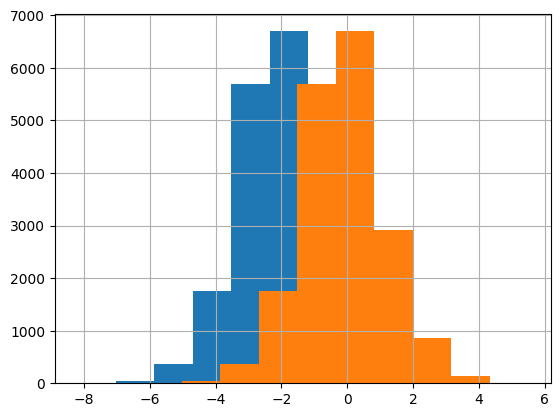

In [ ]:
df["energy_difference"] = df["pred_energy"] - df["true_energy"]
df.energy_difference.hist()
(df["energy_difference"] + 2).hist()


<Axes: >

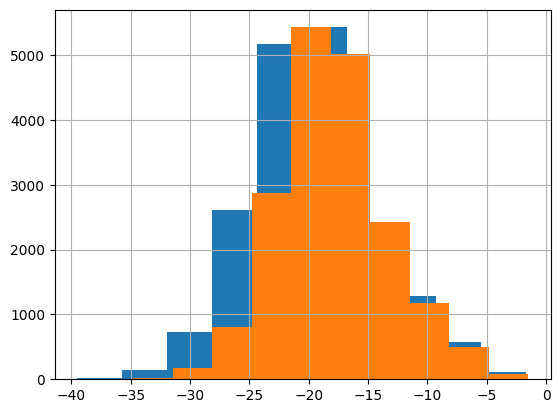

In [ ]:
df.pred_energy.hist()


<Axes: >

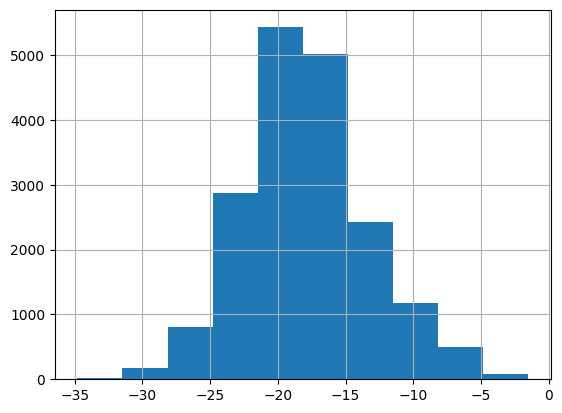

In [ ]:
df.true_energy.hist()

# diff. between base pair numbers

bp_difference
 0     10837
 1      2538
 2      1487
 3       799
-1       793
-2       670
 4       412
-3       283
 5       209
-4       133
 6       114
 7        69
-5        52
-6        32
 8        31
 9        14
-7        13
-8         6
 10        4
-9         2
-11        2
-12        1
Name: count, dtype: int64

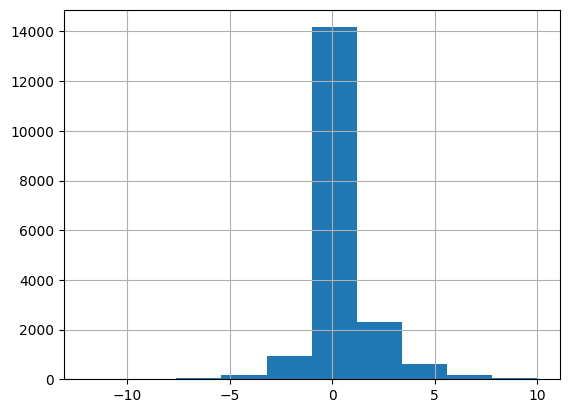

In [ ]:
df["bp_difference"] = df["pred_num_basepairs"] - df["true_num_basepairs"]

df.bp_difference.hist()
df.bp_difference.value_counts()


seed_bp_difference
 0    9042
 1    3725
 2    2300
 3    1391
 4     732
 6     518
 5     417
-1     307
-2      58
-3      11
Name: count, dtype: int64

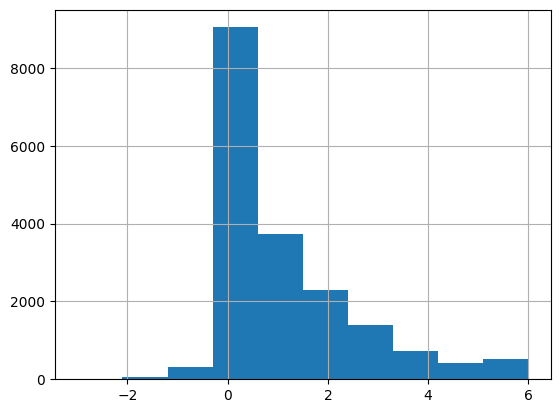

In [ ]:
df["seed_bp_difference"] = df["pred_seed_basepairs"] - df["true_seed_basepairs"]

df.seed_bp_difference.hist()
df.seed_bp_difference.value_counts()

In [ ]:
asd = df.seed_bp_difference.value_counts().to_dict()

asd

NameError: name 'df' is not defined

In [ ]:
print(df[df["true_seed_basepairs"] <= 2].true_seed_type.value_counts())


true_seed_type
none               1500
noseed_9nt_stem    1022
6-mer                19
7-mer                 8
8-mer                 7
Name: count, dtype: int64


In [ ]:
print(df[df["seed_bp_difference"] >= 5].true_seed_type.value_counts())


true_seed_type
none               519
noseed_9nt_stem    403
6-mer                8
8-mer                3
7-mer                2
Name: count, dtype: int64


In [ ]:
print(df[df["seed_bp_difference"] >= 5].true_seed_basepairs.value_counts())



true_seed_basepairs
0    749
1    186
Name: count, dtype: int64


In [ ]:
df["true_folding_class"].value_counts()

true_folding_class
III    4630
V      3602
I      3591
IV     3386
II     3292
Name: count, dtype: int64

In [ ]:
print(df[df["seed_bp_difference"] >= 5].true_seed_type.value_counts())


true_seed_type
none               519
noseed_9nt_stem    403
6-mer                8
8-mer                3
7-mer                2
Name: count, dtype: int64


<Axes: >

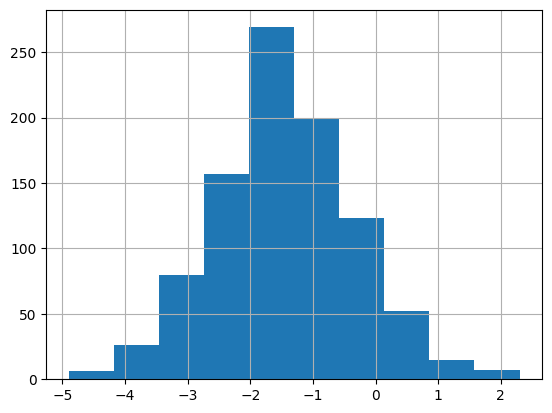

In [ ]:
df[df["seed_bp_difference"] >= 5].energy_difference.hist()

In [ ]:
# 3den büyükler majorly noncanonical bulgular

df.mirna_start.value_counts()


mirna_start
1     10199
2      3030
3      2079
4      1286
5       687
6       302
7       297
8       198
9       120
10      118
13       43
15       33
11       30
16       24
12       20
14       16
17       12
18        7
Name: count, dtype: int64

In [ ]:
df[df["mirna_start"] >= 3].true_seed_type.value_counts()

true_seed_type
none                 2165
noseed_9nt_stem      1628
noncanonical_seed    1336
6-mer                  72
7-mer                  47
8-mer                  20
9-mer                   4
Name: count, dtype: int64

In [ ]:
(72 + 47 + 20 + 4) / (2165 + 1628 + 1336)

0.027880678494833302

In [ ]:
clash_df[clash_df["gene_name"] == "CCNG1"].mirna_name.unique()

array(['let-7a', 'let-7b', 'let-7c', 'let-7e', 'let-7f', 'miR-17*',
       'miR-24', 'miR-100', 'miR-197'], dtype=object)

In [ ]:
df[df["mirna_start"] <= 2].true_seed_type.value_counts()

true_seed_type
noncanonical_seed    5808
none                 1915
7-mer                1592
noseed_9nt_stem      1520
6-mer                1038
8-mer                1026
9-mer                 330
Name: count, dtype: int64

In [ ]:
df[df["true_seed_type"] == "noncanonical_seed"].mirna_start.value_counts()

mirna_start
1     4451
2     1357
3     1237
4       42
5       19
6       13
8        6
7        6
10       5
9        2
13       2
15       1
16       1
14       1
11       1
Name: count, dtype: int64

In [ ]:
df[df["true_seed_type"] == "none"].mirna_start.value_counts()


mirna_start
1     1483
4      648
3      433
2      432
5      365
7      158
6      158
8      113
9       70
10      70
13      31
15      30
16      23
11      17
14      15
12      15
17      12
18       7
Name: count, dtype: int64

In [ ]:
df[df["mirna_start"] >= 4].true_folding_class.value_counts()

true_folding_class
IV     1588
V      1162
I       162
III     160
II      121
Name: count, dtype: int64

In [ ]:
df.head(1)

,id,mrna_start,mrna_dot_bracket_5to3,mrna_end,mirna_start,mirna_dot_bracket_5to3,mirna_end,pred_energy,mrna_slice_5to3,mirna_slice_5to3,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,true_folding_class,mirna_sequence,pred_num_basepairs,pred_seed_basepairs,alignment_string_5to3,temp,energy_difference,bp_difference,seed_bp_difference
0,0727A-1038930_1,23,.(((((((..(((((((((((((.,46,1,)))))))))))))))))))).,21,-27.7,TTTATACAGAACCTACTGCCTCAA,TGAGGTAGTAGGTTGTATAGT,noncanonical_seed,20,6,-25.1,III,TGAGGTAGTAGGTTGTATAGTT,20,6,1111111111111111111100,22,-2.6,0,0


In [ ]:
small_df = df[["true_seed_type", "true_folding_class"]]

small_df

,true_seed_type,true_folding_class
0,noncanonical_seed,III
1,9-mer,II
2,noncanonical_seed,III
3,noncanonical_seed,III
4,noncanonical_seed,III
...,...,...
18496,none,V
18497,7-mer,I
18498,noncanonical_seed,I
18499,6-mer,III


In [ ]:
value_counts = df.groupby(["true_seed_type", "true_folding_class"]).size()
print(value_counts)

true_seed_type     true_folding_class
6-mer              I                      252
                   II                     285
                   III                    366
                   IV                      48
                   V                      159
7-mer              I                      551
                   II                     373
                   III                    544
                   IV                      23
                   V                      148
8-mer              I                      406
                   II                     233
                   III                    332
                   IV                      13
                   V                       62
9-mer              I                      157
                   II                      60
                   III                    107
                   IV                       2
                   V                        8
noncanonical_seed  I                     1

In [ ]:
column1_values = df['true_seed_type']
column2_values = df['true_folding_class']
value_counts = pd.crosstab(column1_values, column2_values)

value_counts

true_folding_class,I,II,III,IV,V
true_seed_type,,,,,
6-mer,252,285,366,48,159
7-mer,551,373,544,23,148
8-mer,406,233,332,13,62
9-mer,157,60,107,2,8
noncanonical_seed,1702,1695,2392,379,976
none,246,284,420,1210,1920
noseed_9nt_stem,277,362,469,1711,329


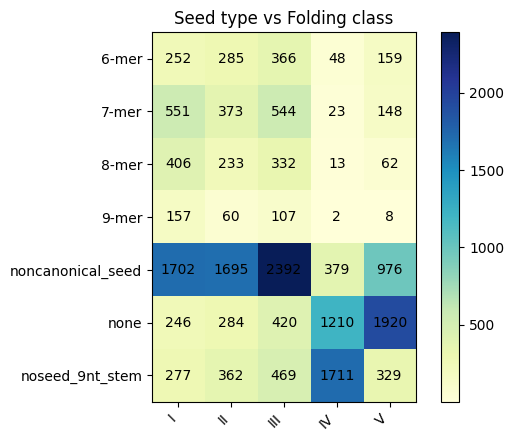

In [ ]:
column1_values = df['true_seed_type']
column2_values = df['true_folding_class']

# Calculate value counts
value_counts = pd.crosstab(column1_values, column2_values)

# Create heatmap
fig, ax = plt.subplots()
heatmap = ax.imshow(value_counts, cmap='YlGnBu')

# Set labels
ax.set_xticks(np.arange(value_counts.shape[1]))
ax.set_yticks(np.arange(value_counts.shape[0]))
ax.set_xticklabels(value_counts.columns)
ax.set_yticklabels(value_counts.index)

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Add colorbar
cbar = ax.figure.colorbar(heatmap)

# Set title
plt.title('Seed type vs Folding class')

# Print values on each box
for i in range(value_counts.shape[0]):
    for j in range(value_counts.shape[1]):
        ax.text(j, i, value_counts.iloc[i, j], ha="center", va="center", color="black")



# # Add row and column sums
# row_sums = value_counts.sum(axis=1)
# col_sums = value_counts.sum(axis=0)

# # Plot row sums
# for i in range(len(row_sums)):
#     ax.text(value_counts.shape[1] + 0.2, i, row_sums.iloc[i], ha="left", va="center", color="green")

# # Plot column sums
# for j in range(len(col_sums)):
#     ax.text(j, value_counts.shape[0] + 0.2, col_sums.iloc[j], ha="center", va="bottom", color="green")


# Show the plot
plt.show()


# yorum

burada saçma bir durum var. folding class 1'ken nasıl none seed type çıkabilir ki?

folding class k-means clustering ile çıkarılmış, demek ki hatalar olabilir

In [ ]:
df.true_seed_type.value_counts()

true_seed_type
noncanonical_seed    7144
none                 4080
noseed_9nt_stem      3148
7-mer                1639
6-mer                1110
8-mer                1046
9-mer                 334
Name: count, dtype: int64

canonical seed interactions:

- pairing between nts 2-7 or 3-8 of the miRNA

noncanonical seed interactions:

- pairing between nts 2-7 or 3-8 of the miRNA, allowing GU pairs, allowing ONE bulged or mismatched nucleotide

- 9 nt stems, allowing bulged nucleotides



In [ ]:
df

,id,mrna_start,mrna_dot_bracket_5to3,mrna_end,mirna_start,mirna_dot_bracket_5to3,mirna_end,pred_energy,mrna_slice_5to3,mirna_slice_5to3,true_seed_type,true_num_basepairs,true_seed_basepairs,true_energy,true_folding_class,mirna_sequence,pred_num_basepairs,pred_seed_basepairs,alignment_string_5to3,temp,energy_difference,bp_difference,seed_bp_difference
0,0727A-1038930_1,23,.(((((((..(((((((((((((.,46,1,)))))))))))))))))))).,21,-27.7,TTTATACAGAACCTACTGCCTCAA,TGAGGTAGTAGGTTGTATAGT,noncanonical_seed,20,6,-25.1,III,TGAGGTAGTAGGTTGTATAGTT,20,6,1111111111111111111100,22,-2.6,0,0
1,L1HS-1112536_1,12,.((((((((.(((((((((.,31,1,))))))))).)))))))).,19,-26.2,CGTGCAACCAACTACCTCAT,TGAGGTAGTAGGTTGTATA,9-mer,17,6,-24.4,II,TGAGGTAGTAGGTTGTATAGTT,17,6,1111111110111111110000,22,-1.8,0,0
2,L2HS-818542_2,4,.(((((((((((((.((((((.,25,1,.)))))).))))))))))))).,22,-23.6,CGCTATATGACCTGATGCCTTT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,19,6,-22.2,III,TGAGGTAGTAGGTTGTATAGTT,19,6,0111111011111111111110,22,-1.4,0,0
3,L2HS-1161339_2,4,.((((((((((((.(((((((.,25,1,)))))))...)))))))))))),22,-23.8,TGACTATGCAACCATACCTTAC,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-22.1,III,TGAGGTAGTAGGTTGTATAGTT,19,6,1111111000111111111111,22,-1.7,1,0
4,L2-407944_2,3,.((((...((((((((((((((.,25,1,))))))))))))))...)))).,22,-24.0,TACTGGGAAACCTGCTACTTCGT,TGAGGTAGTAGGTTGTATAGTT,noncanonical_seed,18,6,-21.9,III,TGAGGTAGTAGGTTGTATAGTT,18,6,1111111111111100011110,22,-2.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18496,L2HS-3158593_1,3,.((((((((((.((.(((.,21,2,.))))))))....)).))))),22,-13.9,CCTGCCCGCCATCATCCTA,CAGGTGTGGAAACTGAGGCAG,none,13,4,-13.5,V,TCAGGTGTGGAAACTGAGGCAG,15,6,0011111111000011011111,22,-0.4,2,2
18497,L2HS-578047_3,3,.(((((((((.,13,2,.))))))))).,12,-21.5,TCCTGGGGGCC,AGCCCCCAGGC,7-mer,9,5,-18.8,I,TAGCCCCCAGGCTTCACTTGGCG,9,6,00111111111000000000000,23,-2.7,0,1
18498,L1HS-550121_2,4,.((((..((((.(((.....(((((.,29,3,.))))))))))))....)))),23,-21.7,ACGCTTGGGAGTCCTCAGCAGGGGGA,GCCCCCAGGCTTCACTTGGCG,noncanonical_seed,17,4,-18.5,I,TAGCCCCCAGGCTTCACTTGGCG,16,6,00011111111111100001111,23,-3.2,-1,2
18499,L2HS-896514_2,1,(((((((((.(((((((.,18,1,))))))))))....)))))).,21,-21.0,TAAGTGCTGTGGGGCTGC,TAGCCCCCAGGCTTCACTTGG,6-mer,15,6,-17.9,III,TAGCCCCCAGGCTTCACTTGGCG,16,6,11111111110000111111000,23,-3.1,1,0


In [ ]:
clash_df.head()

,id,mirna_sequence,true_start,true_end,mrna_sequence,true_seed_type,num_basepairs,seed_basepairs,folding_energy,true_folding_class,mirna_accession,mirna_name,ensg,enst,gene_name
0,0727A-1038930_1,TGAGGTAGTAGGTTGTATAGTT,1791,1890,ATTTGTATCTACGATAAAAATTTTTATACAGAACCTACTGCCTCAA...,noncanonical_seed,20,6,-25.1,III,MIMAT0000062,let-7a,ENSG00000113328,ENST00000340828,CCNG1
1,L1HS-1112536_1,TGAGGTAGTAGGTTGTATAGTT,3857,3928,CAGGAAATACCCGTGCAACCAACTACCTCATATTCCATTCAGAATT...,9-mer,17,6,-24.4,II,MIMAT0000062,let-7a,ENSG00000100697,ENST00000343455,DICER1
2,L2HS-818542_2,TGAGGTAGTAGGTTGTATAGTT,2385,2434,ACCCGCTATATGACCTGATGCCTTTCCTTCATTAAAGATGATTCTG...,noncanonical_seed,19,6,-22.2,III,MIMAT0000062,let-7a,ENSG00000080546,ENST00000436639,SESN1
3,L2HS-1161339_2,TGAGGTAGTAGGTTGTATAGTT,6570,6623,CAATGACTATGCAACCATACCTTACCACTAAATGTAGTACGCAAAA...,noncanonical_seed,18,6,-22.1,III,MIMAT0000062,let-7a,ENSG00000164190,ENST00000282516,NIPBL
4,L2-407944_2,TGAGGTAGTAGGTTGTATAGTT,1164,1208,AATACTGGGAAACCTGCTACTTCGTCAGCTAACCAGAAACCTGTG,noncanonical_seed,18,6,-21.9,III,MIMAT0000062,let-7a,ENSG00000138785,ENST00000340139,INTS12
